In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pyarrow.feather as feather
import wrds
from functions import *
from pandas.tseries.offsets import *
from refit_model import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_seq_items', None)

In [2]:
with open('../feather_files/chars60_raw_imputed.feather_cusip', 'rb') as f:
    chars = feather.read_feather(f)
chars['date'] = pd.to_datetime(chars['date'])
chars['year'] = chars['date'].dt.year

In [4]:
df = chars.copy()

In [5]:
len(df['permno'].unique())

12207

In [63]:
df['permno'] = df['permno'].astype(int)
df['permno'] = df['permno'].astype(str)

In [68]:
print(len(df['permno'].unique()))
print(len(df['gvkey'].unique()))

12207
12207


In [86]:
# 시총 top100
tic_mc100 = df.groupby(['permno']).mean()['me'].sort_values(ascending=False).reset_index()['permno'][:100]
df_mc100 = df[df['permno'].isin(tic_mc100)]

In [87]:
# # 시총 top10
# df.groupby(['permno','ticker','comnam']).mean()[['me']].sort_values(by='me', ascending=False)[:10]
# # 시총 bottom10
# df.groupby(['permno','ticker','comnam']).mean()[['me']].sort_values(by='me')[:10]

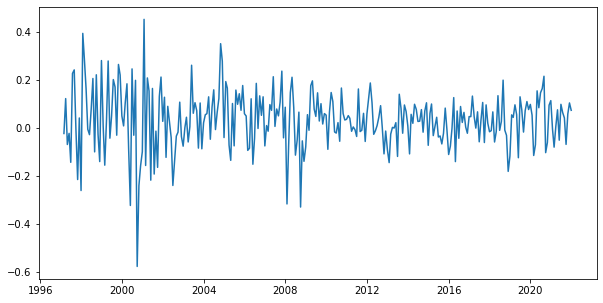

In [99]:
temp = df_mc100[df_mc100['ticker']=='AAPL']
plt.figure(figsize=(10,5))
plt.plot(temp['date'], temp['ret'])

In [126]:
df['permnam'] = df['permno']+' : '+df['comnam']

KeyError: 'permnam'

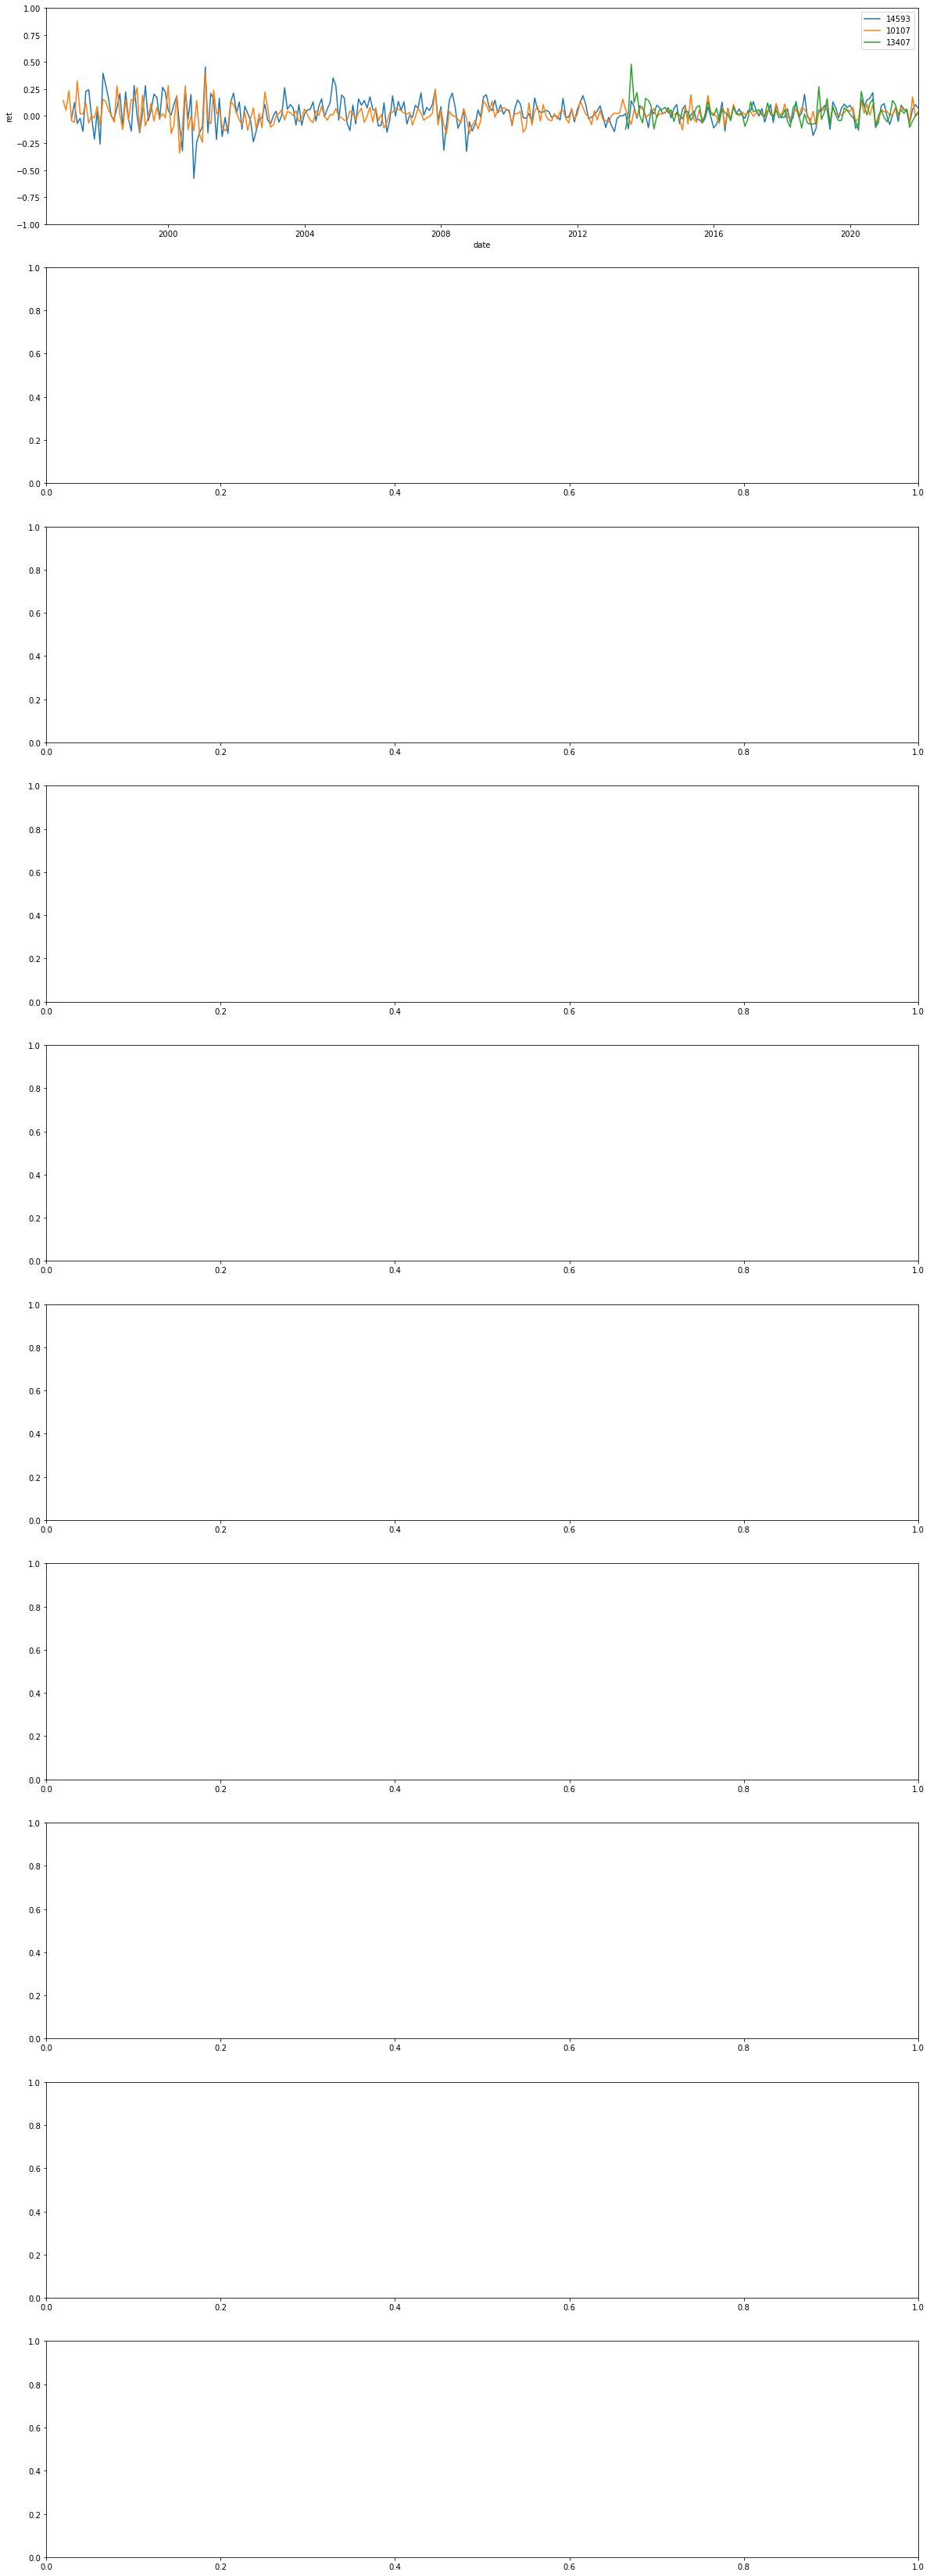

In [128]:
nrow = 1+int(len(tic_mc100)/3)
f, ax = plt.subplots(nrows=10, ncols=1, figsize=(20, 60))

for i in range(len(tic_mc100)):
    temp = df_mc100[df_mc100['permno'].isin(tic_mc100[3*i:3*(i+1)])]
    temp = temp.sort_values(by='me', ascending=False)
    g = sns.lineplot(data=temp, x='date', y='ret', ax=ax[i],
                 ci=None, hue='permno')
    ax[i].legend(loc='upper right')
    g.set(ylim=(-1, 1))
    g.set_xlim(df['date'].min(), df['date'].max())
    g.set_title('%s' % temp['permnam'].unique())
#     lag['%(series)s%(lag)s' % {'series': series, 'lag': i}] = df.groupby('permno')['%s' % series].shift(i)
#     result = df['%s' % series] + lag['%s1' % series] + lag['%s2' % series] + lag['%s3' % series]
    

## Merge with S&P 500 data

In [25]:
conn = wrds.Connection(wrds_username='hangsuck')

Loading library list...
Done


In [56]:
## S&P 500 membership
sp500 = conn.raw_sql("""
                    select a.*, b.date
                    from crsp.msp500list as a,
                    crsp.msf as b
                    where a.permno=b.permno
                    and b.date >= a.start and b.date<= a.ending
                    and b.date>='01/01/1996'
                    and b.date<='12/31/2021'
                    order by date;
                    """, date_cols=['start', 'ending', 'date'])

In [57]:
sp500['year'] = sp500['date'].dt.year
sp500['month'] = sp500['date'].dt.month
df['month'] = df['date'].dt.month

In [58]:
df500 = pd.merge(sp500.drop(['date'], axis=1), df, on=['permno','year','month'], how='inner')

In [59]:
df500.groupby('date').count()

,permno,start,ending,year,month,comnam,ticker,gvkey,sic,ret,exchcd,shrcd,adm,bm_ia,herf,hire,me_ia,ill,maxret,mom12m,mom1m,mom36m,mom60m,mom6m,std_dolvol,me,dy,cinvest,nincr,pscore,acc,bm,agr,alm,ato,cash,cashdebt,cfp,chcsho,chpm,chtx,depr,ep,gma,grltnoa,lev,lgr,ni,noa,op,pctacc,pm,rd_sale,rdm,rna,roa,roe,rsup,sgr,sp,ffi49
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-05-31,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
1996-06-30,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
1996-07-31,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
1996-08-31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31
1996-09-30,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457
2021-09-30,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457
2021-10-31,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457


In [60]:
temp500 = sp500[sp500['date']=='2016-05-31']
temp500

,permno,start,ending,date,year,month
122065,92611.0,2009-12-21,2021-12-31,2016-05-31,2016,5
122066,86158.0,2006-11-17,2021-12-31,2016-05-31,2016,5
122067,92121.0,2007-07-02,2021-12-31,2016-05-31,2016,5
122068,22592.0,1957-03-01,2021-12-31,2016-05-31,2016,5
122069,84032.0,2005-03-14,2021-09-17,2016-05-31,2016,5
...,...,...,...,...,...,...
122565,88845.0,2000-12-14,2018-11-30,2016-05-31,2016,5
122566,13788.0,2013-06-24,2021-12-31,2016-05-31,2016,5
122567,22517.0,1995-11-27,2021-12-31,2016-05-31,2016,5
122568,85072.0,2007-02-02,2021-12-31,2016-05-31,2016,5


In [61]:
temp500.groupby('date').count()

,permno,start,ending,year,month
date,,,,,
2016-05-31,505,505,505,505,505


In [67]:
features = df.columns.drop(['comnam','date','gvkey','permno','sic','ret','ticker']).tolist()
print(features)

# refit_lgb(df, features)

refit_catboost(df, features)

['exchcd', 'shrcd', 'adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'ill', 'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 'std_dolvol', 'me', 'dy', 'cinvest', 'nincr', 'pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho', 'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni', 'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe', 'rsup', 'sgr', 'sp', 'ffi49', 'year', 'month']
train:  1996 2011
valid:  2012


/Users/jiwonpark/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0186
train:  1996 2012
valid:  2013
0.0393
train:  1996 2013
valid:  2014
-0.0002
train:  1996 2014
valid:  2015
0.0007
train:  1996 2015
valid:  2016
0.0179
[0.0186, 0.0393, -0.0002, 0.0007, 0.0179]


0.015260000000000001